In [143]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt

# set the random number generator
np.random.seed(42)

In [274]:
import csv
import string
import pathlib

# Load Data and Inspect
The data is in `./websplit` folder.  

In [34]:
raw_sentences = []  # empty list to store sentences
with open("websplit/test.tsv", "r") as f:
    reader = csv.reader(f, delimiter='\t')  # read a tsv file
    for row in reader:
        # print("Original Sentence:", row[0])      # Uncomment to view data
        # print("Split sentences", row[1].split("<::::>"))
        # print("\n")
        
        raw_sentences.extend(row[1].split("<::::>"))
print("Total Sentences: ", len(raw_sentences))

Total Sentences:  10000


In [35]:
# Some samples
print(raw_sentences[99], '\n', raw_sentences[100])

 He was was arrested and booked on charges of first - degree murder and first - degree robbery . 
 A 2006 estimate by the International Organization for Migration put the number of Sudanese people in the UK at a much higher figure . 


In [220]:
# As we see there are lots of punctuations which we dont have in EMNIST, so we are going to remove them, 
# and replace multiple spaces with one
import re

sentences = []
table = str.maketrans({key: None for key in string.punctuation})  # translation table

for sentence in raw_sentences:
    # remove punctuation and non-ascii characters
    clean_sentence = re.sub('  +', ' ', sentence.translate(table)).\
                        encode("ascii", 'ignore').decode()  
    sentences.append(clean_sentence.strip())  # add to clean sentences
    
print(sentences[99], '\n', raw_sentences[99])  # to verify

He was was arrested and booked on charges of first degree murder and first degree robbery 
  He was was arrested and booked on charges of first - degree murder and first - degree robbery .


# Make Images for Sentences

### First step is to load the EMIST data and the mapping table

In [37]:
import sys
sys.path.append('../')  # so that we can import libs from other chapters and utils

from utils import emnist_utils

In [38]:
######## GPU CONFIGS FOR RTX 2070 ###########
## Please ignore if not training on GPU ##
from tensorflow.keras import backend as K
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True  # dont allocate all memory at once
config.gpu_options.allocator_type = 'BFC'  #A "Best-fit with coalescing" algorithm, simplified from a version of dlmalloc
config.gpu_options.per_process_gpu_memory_fraction = 2.0  # Use host memory as swap space, may not work on all architectures
config.log_device_placement=True
session = InteractiveSession(config=config)
K.set_session(session)
##########################################

In [39]:
# Load train and test data from Chapter 1 location
train = {}
test = {}

train['features'], train['labels'] = emnist_utils.read_emnist('../Chapter1/data/emnist-bymerge-train-images-idx3-ubyte.gz', '../Chapter1/data/emnist-bymerge-train-labels-idx1-ubyte.gz')
test['features'], test['labels'] = emnist_utils.read_emnist('../Chapter1/data/emnist-bymerge-test-images-idx3-ubyte.gz', '../Chapter1/data/emnist-bymerge-test-labels-idx1-ubyte.gz')

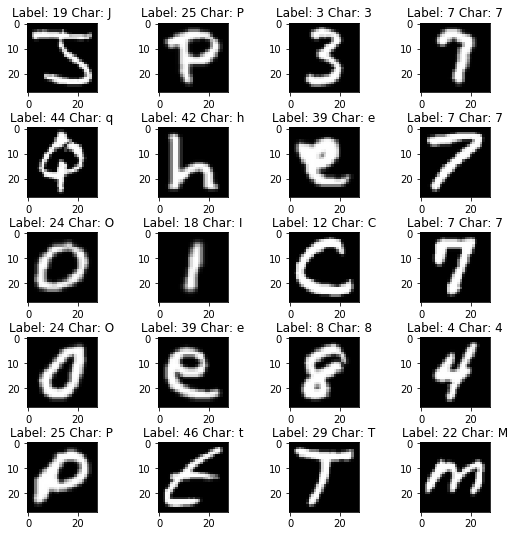

In [40]:
mappings = emnist_utils.map_emnist_labels("../Chapter1/data/emnist-bymerge-mapping.txt")
# Plot some images to verify we got the data right
emnist_utils.display_emnist_images(test['features'], test['labels'], mappings)

In [58]:
# To help in converting a list of characters into a sequence of images, 
# we need a list of image IDs corresponding to the same character
# or number. So, a reverse index needs to be generated
image_index = {}  # where key is the char and value is a list of IDs
for idx, code in enumerate(train['labels'].tolist()):
    char = mappings[code]
    if char in image_index:
        # this character already exists
        image_index[char].append(idx)  # append index
    else:
        image_index[char] = [idx]  # initiate list with 1 item

### Second step is to load sentence at a time, create set of images that can be joined with each other to produce the sentence.

In [216]:
def get_sample_sentences(sentences_in=sentences, num_sentence=10):
    # Get a defined number of sentences from the data
    return np.random.choice(sentences_in, num_sentence)

def get_generated_image(words, chars=train['features'], index=image_index):
    # words is string of char/numbers that needs to be converted into an image
    # chars is a data set of images that need to be used to compose, usually pass in train['features'] in here
    # index maps a character to indexes in the images, available as dictionary
    height, width = train['features'][0].shape # height and width of each character
    length = len(words) # total number of characters in the image
    
    # create an empty array to store the data
    image = np.zeros((height, width * length))
    pos = 0  # starting index of the character
    
    for char in words:
        if char is ' ':
            pos += width # if space, move over
        else:
            if char in image_index:
                # pick a random item from all images for that char
                idx = np.random.choice(image_index[char])  
                image[:, pos:(pos+width)] += chars[idx]
            elif char.upper() in image_index:  # to remove characters from other languages
                # for some characters, there is only upper case
                idx = np.random.choice(image_index[char.upper()])  
                image[:, pos:(pos+width)] += chars[idx]
            
            pos += width
    
    return image

['His maternal grandparents were Henry III of England and Eleanor of Provence']


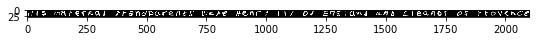

In [287]:
# Let's print a sample to see how it looks
s = get_sample_sentences(sentences, 1)
print(s)
img = get_generated_image(s[0])
plt.figure(figsize=(9,2))
plt.imshow(img, cmap='gray')
plt.show()

### Third step is to generate a number of sentences for training and testing and save them to disk for processing

In [271]:
train_sentences = sentences[:9000]
test_sentences = sentences[9000:]

# Lets assume that for each training sample, 2 variants will be generated

def generate_sentences(texts, chars, 
                           index, num_variants=2, max_length=32):
    # this method takes input text lines, character samples and labels
    # and generates images. It can generate multiple images per sentence
    # as controlled by num_variants parameter. max_length parameter
    # ensures that all sentences are the same length
    
    # total number of samples to generate
    num_samples = len(texts) * num_variants
    height, width = chars[0].shape  # shape of image
    
    # setup empty array of the images
    images = np.zeros((num_samples, height, width * max_length), np.float64)
    labels = []
    
    for i, item in enumerate(texts):
        padded_item = item[0:max_length] if (len(item) > max_length) else item.ljust(max_length, ' ')
        
        for v in range(num_variants):
            img = get_generated_image(padded_item, chars, index)
            images[i*num_variants+v, :, :] += img
            labels.append(padded_item)
    
    return images, labels

In [275]:
train_images, train_labels = generate_sentences(train_sentences, train['features'], image_index)
test_images, test_labels = generate_sentences(test_sentences, train['features'], image_index)

In [278]:
# Now to save these models for easy loading
pp = pathlib.Path('.') / 'sentences'
pp.mkdir(exist_ok=True)  # create the directory

np.save(pp / 'train_images', train_images)
np.save(pp / 'test_images', test_images)
np.save(pp / 'train_labels', train_labels)
np.save(pp / 'test_labels', test_labels)

# Building the Model to Recognize Sentences